# 4ab Creating a Multigrid Poisson Solver
Multigrid solvers are built on a few key observations:
  * Iterative solvers, like the Jacobi solver, correct the small scale errors of a solution faster than the large scale errors
  * The solution to the Poisson equation can be used to formulate an analogous equation for the solution of the error term
  * By using a __restriction operator__ we can solve the equation for the error term on a coarse mesh
  * By using a __prolongation operator__ we can propogate the solution for the error term from the coarse to the fine mesh
  * This can be done recursively
  * Solving on the coarse mesh is cheaper by a factor 2^ndim

In this exercise you will get the chance to build a nice recursive piece of code by yourself and create a multigrid solver. Below are only given the logical pieces, the rest you have to create.

_This exercise counts for the full week_

## Preparation:
At the bottom write a section heading, "Solution", and copy the multigrid class and the small piece of to run the solver below it. This gives you a clean reference code above, and makes it easier to see what has been modified.

#### Task 1 (40 pt):  
Create the prolongation and restriction operators, and the central recursive algorithm (see the code below).

#### Task 2 (40 pt):
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.

#### Task 3 (20 pt):
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?

#### Extra open task  (up to 20 pt):
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle). Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
np.set_printoptions(linewidth=120)

### Small function for showing images of 2D arrays

In [2]:
def imshow(f,title='',**kwargs):
    """ Show an image, with preferred orientation """
    plt.imshow(np.transpose(f),origin='lower',**kwargs)
    plt.colorbar()
    plt.title('{}  max:{:.4f}  min:{:.4f}'.format(title,f.max(),f.min()));

def imshows(f,title='',**kwargs):
    f=np.array(f)
    if f.ndim==2:
        imshow(f,title,**kwargs)
    else:
        n=f.shape[0]
        rows=1+(n-1)//3
        cols=min(n,3)
        plt.figure(figsize=(cols*5,rows*4))
        for i in range(n):
            plt.subplot(rows,cols,1+i)
            if type(title) is np.ndarray:
                t=title[i]
            else:
                t=title
            imshow(f[i,:,:],t,**kwargs);

### Class for initial conditions

In [3]:
class BonnorEbert():
    """ Simple 1/(r+rc)^2 for r < r0 density distribution """
    def __init__(u,n=(32,32,32),G=1,L=2,r0=0.5,rc=0.1):
        # make n a 3-tuple if given as an integer
        if isinstance(n, int):
            m = (n,n,n)
        else:
            m = n
        u.n = m                             # number of grid points
        u.ds = L / m[0]                     # cell size
        # make cell centered coordinates with domain boundaries [-L/2:L/2]^ndim
        LL = 0.5*u.ds*m[0], 0.5*u.ds*m[1], 0.5*u.ds*m[2]
        u.x = np.linspace(-LL[0],LL[0],m[0], endpoint=False) + 0.5 * u.ds # cell centered coordinates
        u.y = np.linspace(-LL[1],LL[1],m[1], endpoint=False) + 0.5 * u.ds
        u.z = np.linspace(-LL[2],LL[2],m[2], endpoint=False) + 0.5 * u.ds
        u.coords = np.array(np.meshgrid(u.x,u.y,u.z,indexing='ij')) # expand to 3D grid
        u.r = np.sqrt(np.sum(u.coords**2,axis=0)) # spherical radius
        u.L = L * np.array(m) / m[0]        # box size in all three directions
        u.G    = G                          # Newtons constant of gravity
        u.D = np.zeros(m)                   # density
        ii = np.where(u.r <= r0)
        u.D[ii] = 1. / (u.r[ii]+rc)**2


### Jacobi solver and computation of residual

In [4]:
def Jacobi_residual(Phi,S):
    """ calculate explicit residual for given Phi, S """
    n = Phi.shape        # grid size
    res = np.copy(S)
    for i in range(3):
        if n[i] > 1:
            res += (np.roll(Phi,+1,axis=i)+np.roll(Phi,-1,axis=i)) - 2.*Phi
    # fix boundaries
    if n[0] > 2:
        res[0,:,:] = res[-1,:,:] = 0.
    if n[1] > 2:
        res[:,0,:] = res[:,-1,:] = 0.
    if n[2] > 2:
        res[:,:,0] = res[:,:,-1] = 0.
    return res

def Jacobi(Phi,S):
    """ Jacobi iteration for multi-grid self-gravity """
    n = Phi.shape  # grid size

    const = 0.     # Prefactor for normalising dimensions (2 * ndim)
    #   phi = 1/(2ndim) (phi(i-1,j,k)+phi(i+1,j,k)+... - 4 pi G ds^2 rho)
    #   Pad Phi with zeros in each direction for boundary values (assumed to be zero) using numpy.pad
    Phi_new = np.copy(S)   # copy source
    if n[0] > 1:
        const += 2.
        PP = np.pad(Phi, ((1,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=0)+np.roll(PP,-1,axis=0))[1:-1,:,:]
    if n[1] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(1,1),(0,0)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=1)+np.roll(PP,-1,axis=1))[:,1:-1,:]
    if n[2] > 1:
        const += 2.
        PP = np.pad(Phi, ((0,0),(0,0),(1,1)), 'constant', constant_values=(0., 0.))
        Phi_new += (np.roll(PP,+1,axis=2)+np.roll(PP,-1,axis=2))[:,:,1:-1]

    Phi_new *= (1./const) # normalise

    # Return solution and residual (Phi_new - Phi = S + Laplace Phi)
    return Phi_new, Phi_new - Phi

### Iterative Jacobi solver for selfgravity

In [5]:
class poisson():
    def __init__(self, u, tolerance=1e-4,maxit=2000):
        """ Initialize a Poisson solver """
        self.n         = u.n       # Mesh size
        self.maxit     = maxit     # Maximum number of iterative steps to take
        self.tolerance = tolerance # Tolerance to satisfy for the error

    # Iterative Solver for the Poisson Problem
    def Poisson(self,u):
        S = -(4.*np.pi*u.G)*u.D*u.ds**2
        norm   = np.amax(np.abs(S))
        Phi = np.zeros(self.n)        # Start guess =0
        self.it = 0; self.error = self.tolerance
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi, residual = Jacobi(Phi,S)
            self.error = np.amax(np.abs(residual) / norm)
            self.it+=1
            
        residual = Jacobi_residual(Phi,S)
                    
        return Phi, self.it, self.error, residual

### Driver for calling the Jacobi solver

Nr of iterations, error, tolerance : 992 9.98e-05 1.0e-04
Time = 0.7 seconds, 20.0 musec/cell, 20.2 nanosec/cell/it


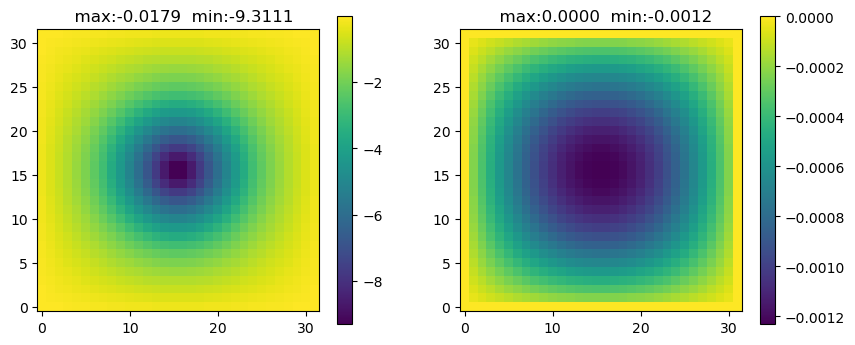

In [6]:
u = BonnorEbert(n=32,rc=0.1, r0=0.5)
P = poisson(u,maxit=8000,tolerance=1e-4)

start = time()
Phi, nt, err, res = P.Poisson(u)
used = time() - start
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(nt, err, P.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(used,1e6*used/ntot,1e9*used/(ntot*nt)))

# Show solution, Phi, and residual, res, side-by-side
imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

### Investigating the solution

Plot the size of the potential, $\Phi$, as a function of distance from center $r$. Notice how it strays from a perfect spherical solution because we restrict it to be zero on the boundary

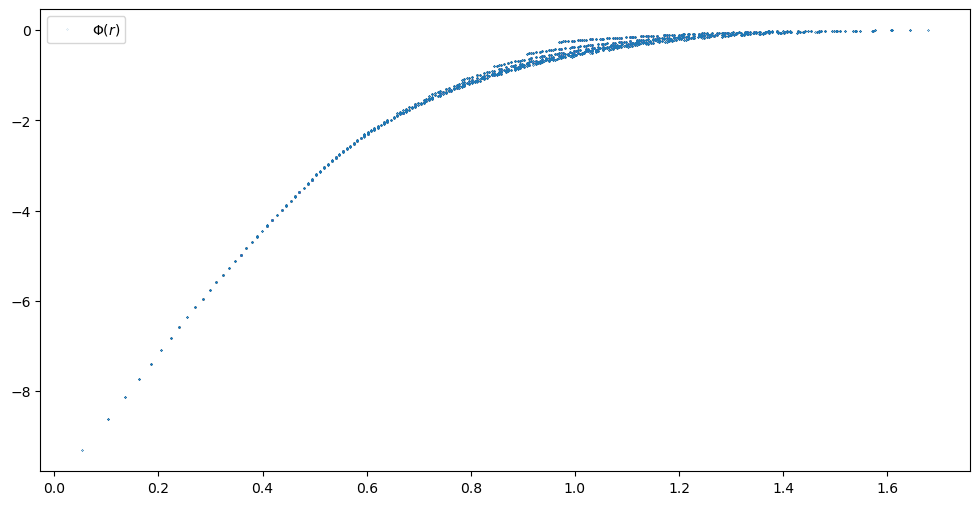

In [7]:
f = plt.figure(figsize=(12,6))
plt.plot(u.r.ravel(),Phi.ravel(),'o',markersize=0.1,label=r'$\Phi(r)$')
plt.legend();

### Multigrid Solver

Make a Multigrid solver class / object, which given a hydro object finds the solution for the potential

In [8]:
class Multigrid():
    def __init__(self,u,tolerance=1e-5,maxit=1000, verbose = 1):
        """ initialize Poisson solver class for u """
        self.maxit = maxit          # maximum number multigrid iterations. Depends on tolerance
        self.tolerance = tolerance  # tolerance to satisfy for the error
        self.first_time = [True]*20 # flag to print info on each level only once. Works up to resolution of 2**20
        self.verbose = verbose      # print info on each level

    def print_info(self,level,n):
        """ Print info about current level and grid size """
        if self.first_time[level]:
            print ("MG level = {} n = {} can_restrict = {}".format(level, n, self.can_restrict(n)))
            self.first_time[level] = False

    def can_restrict(self,n):
        """ Test if we can divide any resolution by 2 """
        for i in range(len(n)):
            if n[i] > 2 and n[i] % 2 == 0:
                return True
            
        return False

    def restrict(self,f_fine):
        """ restrict residual to coarser level by taking every second element """
        n = np.array(np.shape(f_fine))
        f_coarse = np.zeros((n[0]//2,n[1]//2,n[2]//2))
        f_coarse[:,:,:] = f_fine[::2,::2,::2]

        return f_coarse

    def prolong(self,f_coarse):
        """ prolong solution to finer level by copy for every second point and average for every second point """
        x, y, z = f_coarse.shape
        
        # Interleave the original array with the calculated averages along each dimension
        f_fine = np.empty((2 * x, 2 * y, 2 *z))

        
        # Calculate average values along each dimension
        # pad f_coarse with zeros to make it the same size as f_fine in x 
        f_coarse_x = np.pad(f_coarse, ((0,1),(0,0),(0,0)), 'constant', constant_values=(0., 0.))
        averages_x = 0.5 * (f_coarse_x[:-1, :, :] + f_coarse_x[1:, :, :])

        # pad f_coarse with zeros to make it the same size as f_fine in y
        f_coarse_y = np.pad(f_coarse, ((0,0),(0,1),(0,0)), 'constant', constant_values=(0., 0.))
        averages_y = 0.5 * (f_coarse_y[:, :-1, :] + f_coarse_y[:, 1:, :])

        # pad f_coarse with zeros to make it the same size as f_fine in z
        f_coarse_z = np.pad(f_coarse, ((0,0),(0,0),(0,1)), 'constant', constant_values=(0., 0.))
        averages_z = 0.5 * (f_coarse_z[:, :, :-1] + f_coarse_z[:, :, 1:])

        # Fill in the odd indices with the original array
        f_fine[::2, ::2, ::2] = f_coarse

        # Fill in the even indices with the average values
        f_fine[1::2, ::2, ::2] = averages_x
        f_fine[::2, 1::2, ::2] = averages_y
        f_fine[::2, ::2, 1::2] = averages_z

        f_fine[1::2, 1::2, ::2] = 0.5 * (averages_x[:, :, :] + averages_y[:, :, :]) 
        f_fine[1::2, ::2, 1::2] = 0.5 * (averages_x[:, :, :] + averages_z[:, :, :])
        f_fine[::2, 1::2, 1::2] = 0.5 * (averages_y[:, :, :] + averages_z[:, :, :])

        f_fine[1::2, 1::2, 1::2] = 0.25 * (averages_x[:, :, :] + averages_y[:, :, :] + averages_z[:, :, :])

        # print("Percentage of zeros in the fine grid: {:.2f}".format(100*np.sum(f_fine==0)/f_fine.size))
                
        return f_fine



    # The heart of the multigrid algorithm. This function should call itself recursively.
    # As given, it just updates Phi and does two times it smooth Jacobi iterations
    def Vcycle(self,Phi,source,level):
        Phi[:,:,:], _ = Jacobi(Phi,source) # improve solution at grid-scale
        r0 = Jacobi_residual(Phi,source)

        n = Phi.shape
        if self.verbose:
            self.print_info(level,n) # print some info first time this level is visited
        if self.can_restrict(n): # if not on coarsest level, recurse
            level_coarse = level + 1
            # 1. restrict *residual* from current to coarse level
            r1 = self.restrict(r0)
            # 2. call solve at coarser level (e.g. level+1)
            # make new guess
            e0 = np.zeros_like(r1)

            Phi_new = self.Vcycle(r1, e0, level_coarse)
            # 3. prolong the solution for Phi from the coarser level (=level+1) and add to solution on this level
            Phi += self.prolong(Phi_new)
            
        Phi[:,:,:], _ = Jacobi(Phi,source) # improve solution at grid-scale
        return Phi

    def full_solve(self,Phi,source):
        norm   = np.amax(np.abs(source))                  # normalisation for residual
        self.it = 0
        self.error = self.tolerance
        # Main loop
        while self.error >= self.tolerance and self.it<self.maxit:
            Phi = self.Vcycle(Phi,source,0)          # do a full V-shaped multigrid cycle
            self.it += 1                             # inc nr of MG iterations
            res = Jacobi_residual(Phi,source)        # compute residual
            self.error = np.amax(np.abs(res) / norm) # estimate error
            
        return Phi, res

MG level = 0 n = (32, 32, 32) can_restrict = True
MG level = 1 n = (16, 16, 16) can_restrict = True
MG level = 2 n = (8, 8, 8) can_restrict = True
MG level = 3 n = (4, 4, 4) can_restrict = True
MG level = 4 n = (2, 2, 2) can_restrict = False
Nr of iterations, error, tolerance : 763 9.92e-05 1.0e-04
Time = 5.8 seconds, 177.7 musec/cell, 179.1 nanosec/cell/it


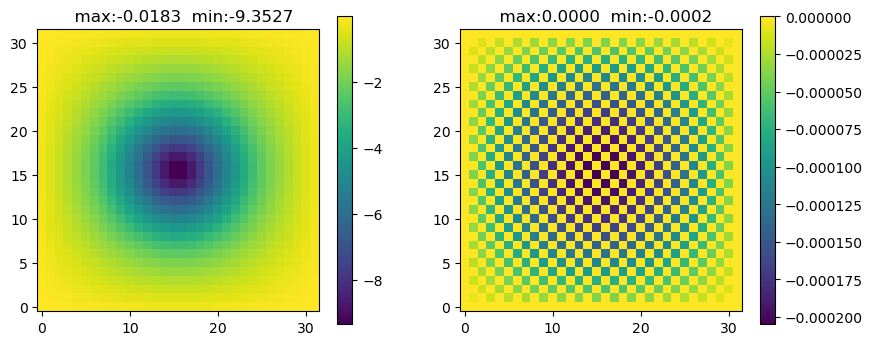

In [9]:
n=32
u = BonnorEbert(n=n,rc=0.1, r0=0.5)         # Compute the density distribution
M = Multigrid(u,maxit=5000,tolerance=1e-4)  # Setup the Multigrid solver object

start = time()              # for timing

Phi = np.zeros(u.n)         # initial guess for Phi
S = -(4.*np.pi*u.G)*u.D*u.ds**2 # source term
Phi, res = M.full_solve(Phi,S)  # call the multigrid solver
used = time() - start       # for timing

# print some statistics
ntot = u.n[0]*u.n[1]*u.n[2]
print("Nr of iterations, error, tolerance : {} {:.2e} {:.1e}".format(M.it, M.error, M.tolerance))
print("Time = {:.1f} seconds, {:.1f} musec/cell, {:.1f} nanosec/cell/it".format(
    used,1e6*used/ntot,1e9*used/(ntot*nt)))

# show potetial and residual
imshows(np.array( [Phi[:,:,u.n[2]//2],res[:,:,u.n[2]//2]]))

----
#### Add your solution below


#### Task 2 (40 pt):
Validate the solver. Multigrid solvers have the central property that, for a given tolerance, the number of needed multigrid cycles only depends weakly on the resolution
Compare with a simple Jacobi integrator. Notice the ```maxit```option that may have to be increased for it to converge, if you go to high resolutions.


In [10]:
def time_multigrid(n, tolerance):
    u = BonnorEbert(n=n,rc=0.1, r0=0.5)         # Compute the density distribution
    M = Multigrid(u,maxit=10000,tolerance=tolerance, verbose=0)  # Setup the Multigrid solver object

    start = time()              # for timing

    Phi = np.zeros(u.n)         # initial guess for Phi
    S = -(4.*np.pi*u.G)*u.D*u.ds**2 # source term
    Phi, res = M.full_solve(Phi,S)  # call the multigrid solver
    used = time() - start       # for timing

    return used


def time_jacobi(n, tolerance):
    u = BonnorEbert(n=n,rc=0.1, r0=0.5)         # Compute the density distribution
    P = poisson(u,maxit=10000,tolerance=tolerance)  

    start = time()              # for timing

    Phi, nt, err, res = P.Poisson(u)
    used = time() - start       # for timing

    return used

multi_tolerances = []
jacobi_tolerances = []
for tolerance in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    used = time_multigrid(32, tolerance)
    print("Multi | Tolerance: {:.0e}, Time: {:.2f} seconds".format(tolerance, used))
    multi_tolerances.append(used)

    used = time_jacobi(32, tolerance)
    print("Jacobi | Tolerance: {:.0e}, Time: {:.2f} seconds".format(tolerance, used))
    jacobi_tolerances.append(used)

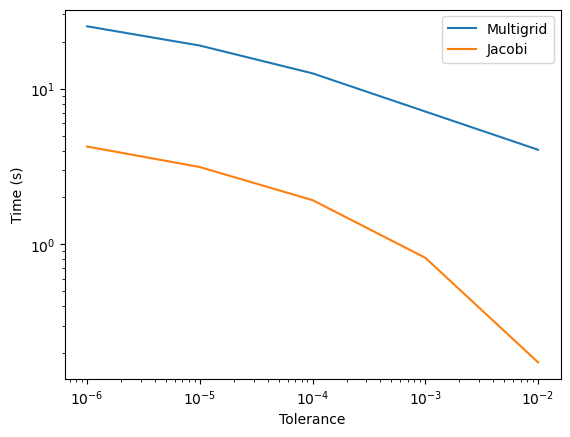

In [74]:
plt.plot([1e-2, 1e-3, 1e-4, 1e-5, 1e-6], multi_tolerances, label="Multigrid")
plt.plot([1e-2, 1e-3, 1e-4, 1e-5, 1e-6], jacobi_tolerances, label="Jacobi")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Tolerance")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


#### Task 3 (20 pt):
Timing: at what resolution does your multigrid solver become faster than the Jacobi solver?


In [13]:
multi_n = []
jacobi_n = []

for n in [8, 16, 32, 64, 128]:
    used = time_multigrid(n, 1e-6)
    print("Multi | n: {}, Time: {:.2f} seconds".format(n, used))
    multi_n.append(used)
    used = time_jacobi(n, 1e-6)
    print("Jacobi | n: {}, Time: {:.2f} seconds".format(n, used))
    jacobi_n.append(used)


Multi | n: 8, Time: 0.72 seconds
Jacobi | n: 8, Time: 0.13 seconds
Multi | n: 16, Time: 3.22 seconds
Jacobi | n: 16, Time: 0.44 seconds
Multi | n: 32, Time: 17.95 seconds
Jacobi | n: 32, Time: 3.13 seconds
Multi | n: 64, Time: 403.94 seconds
Jacobi | n: 64, Time: 478.29 seconds


KeyboardInterrupt: 

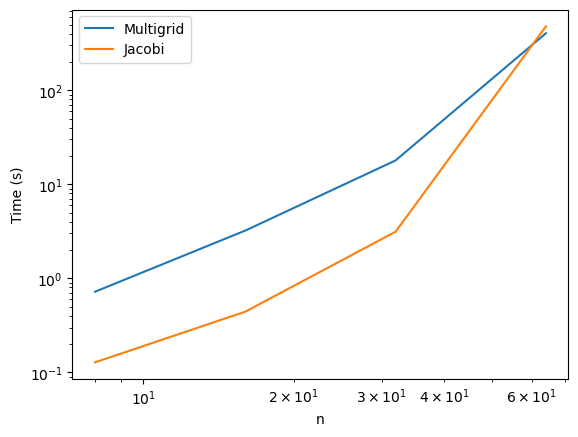

In [14]:
plt.plot([8, 16, 32, 64, ], multi_n, label="Multigrid")
plt.plot([8, 16, 32, 64, ], jacobi_n, label="Jacobi")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


#### Extra open task  (up to 20 pt):
The convergence properties of a multi grid solver can be be improved by not doing the full cycle up and down (V-cycle), but instead first going all the way down, then half way up, down again, and then all the way up (W-cycle). Change the solver to a W-cycle, or explore other cycle configurations (see e.g. the link at the end of the slides). 